In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from collections import Counter
from helpers import regret

We first define transformations $f$ and $h$ such that for a learner's action $a$ and an adversary's action $b$, cost($a$, $b$) = $\langle f(a), h(b) \rangle$.

In [9]:
def linearize_learner(anow, kappa):
    """
    Linearize the learner's action to a vector of length 2T.
    """
    T = len(anow)
    a_prev_step = np.concatenate(([0], [np.sum(anow[:i+1]) for i in range(T)])) # a_prev_step[t] = a[t-1] (zero permanent impact on first step)
    return np.concatenate((anow, [anow[t] * (anow[t] + kappa * a_prev_step[t]) for t in range(T)]))

def linearize_adversary(anow, kappa):
    """
    Linearize the adversary's action to a vector of length 2T.
    """
    T = len(anow)
    a_prev_step = np.concatenate(([0], [np.sum(anow[:i+1]) for i in range(T)])) # a_prev_step[t] = a[t-1] (zero permanent impact on first step)
    return np.concatenate(([anow[t] + kappa * a_prev_step[t] for t in range(T)], [1 for t in range(T)]))

Next we give a best response oracle that FTPL will invoke to select the next action. The algorithm follows the DP best response algorithm but can handle any cost function that can be written as cost($a$, $b$) = $\sum_{t=1}^T c(t; a(t), a'(t), b)$. We will call the $c$ the *one step cost*.

In [10]:
def best_response_oracle(one_step_cost, T, kappa, V, lower_limit, upper_limit):
    """
    Implements best response oracle for cost function c(a, b) = sum_{t=1}^T one_step_cost(t, a(t), a'(t), b)
    
    Args:
        one_step_cost (callable): Function that returns cost at time t
        T (int): Number of time steps
        kappa (float): Market impact parameter
        V (float): Total volume to trade
        lower_limit (float): Minimum trading rate per time step
        upper_limit (float): Maximum trading rate per time step

    Returns:
        array: Optimal trading schedule that minimizes total cost
    """

    # helper functions to determine min/max number of remaining shares at each time step
    # shares remaining are between [V-upper_limit*t, V-lower_limit*t] at time t
    def min_remaining(t):
        return V - upper_limit * t
    def max_remaining(t):
        return V - lower_limit * t

    s_size = max_remaining(T) - min_remaining(T) + 1 # range of remaining shares
    dptable = np.full((T, s_size), np.inf) # initialize table of optimal costs
    dpaction = np.zeros((T, s_size))  # initialize table of optimal actions

    # helper function to map remaining shares s at time t to DP table index
    def s_to_index(s):
        return s - min_remaining(T)

    # initialization: on last step (t = T), must buy/sell all remaining shares
    for s in range(min_remaining(T), max_remaining(T) + 1):
        if lower_limit <= s <= upper_limit: # must adhere to trading limits
            i = s_to_index(s)
            dptable[T-1,i] = one_step_cost(T-1, V, s, kappa)
            dpaction[T-1,i] = s

    # populate DP table from time step T-2 to 0
    for t in reversed(range(T-1)):  
        for s in range(min_remaining(t), max_remaining(t) + 1):  # shares remaining at time r
            i = s_to_index(s) # corresponding index in DP table

            # find optimal number of shares to trade now
            mincost = np.inf
            for q in range(lower_limit, upper_limit + 1): # possible shares to trade
                next_s = s - q # remaining shares after buying q shares

                next_i = s_to_index(next_s) 
                if t == 0:
                    # at first step, shares remaining s = V
                    thisval = dptable[t+1,next_i] + one_step_cost(t, q, q, kappa)
                else:
                    thisval = dptable[t+1,next_i] + one_step_cost(t, V-s+q, q, kappa)

                if thisval < mincost: 
                    dptable[t,i] = thisval
                    dpaction[t,i] = q
                    mincost = thisval

    # compute optimal strategy for A from DP table
    anow = np.zeros(T)

    # traverse DP table, starting from time step 0 with V shares remaining
    volrem = V
    for t in range(T):
        i = s_to_index(int(volrem))
        anow[t] = int(dpaction[t,i])
        volrem -= anow[t]

    # return optimal strategy a'
    return anow

Next we implement one round of Follow the Perturbed Leader (FTPL).

In [11]:
def get_ftpl_action(cumulative_cost, epsilon, kappa, V, lower_limit, upper_limit):

    """
    Implements one round of FTPL.

    Args:
        cumulative_cost (numpy.ndarray): Cumulative linearized cost vector of length 2T, where T is the number of time steps.
        epsilon (float): Noise parameter
        kappa (float): Market impact parameter.
        V (int): Total volume to be traded.
        lower_limit (int): Minimum number of shares that can be traded in one time step.
        upper_limit (int): Maximum number of shares that can be traded in one time step.

    Returns:
        numpy.ndarray: Trading schedule returned by FTPL
    """

    d = len(cumulative_cost)
    T = int(d/2)

    # draw noise vector from [0, epsilon]^d uniformly at random
    noise = np.random.uniform(0, epsilon, d)

    # compute noisy cost
    noisy_cumulative_cost = np.add(cumulative_cost, noise)

    def one_step_cost(t, a_t, anow_t, kappa): # cost at time step t of FTPL objective (t=0,...,T-1)
        return anow_t * noisy_cumulative_cost[t] + anow_t * (anow_t + kappa * (a_t - anow_t)) * noisy_cumulative_cost[T+t]

    # compute optimal action wrt noisy cumulative cost
    ftpl_action = best_response_oracle(one_step_cost, T, kappa, V, lower_limit, upper_limit)

    return ftpl_action

Now we implement no regret dynamics.

In [12]:
def no_regret_dynamics(num_rounds, T, epsilon, kappa, Va, Vb, lower_limit, upper_limit, print_flag=True):
    """
    Simulates no regret dynamics between 2 players who concurrently run FTPL.

    Args:
        num_rounds (int): Number of rounds of play.
        T (int): Number of time steps.
        epsilon (float): Noise parameter for FTPL.
        kappa (float): Market impact parameter.
        Va (int): Total volume to be traded by player A.
        Vb (int): Total volume to be traded by player B.
        lower_limit (int): Minimum number of shares that can be traded in one time step.
        upper_limit (int): Maximum number of shares that can be traded in one time step.
        print_flag (bool, optional): If True, prints info and plots strategies at every round. Defaults to True.

    Returns:
        tuple:
            - list: Actions played by player 1.
            - list: Actions played by player 2.
            - list: Cost vectors seen by player 1.
            - list: Cost vectors seen by player 2.
            - list: Costs incurred by player 1 in each round.
            - list: Costs incurred by player 2 in each round.
            - list: Regret of player 1 after every round.
            - list: Regret of player 2 after every round.
    """

    d = 2*T

    p1_actions = []
    p2_actions = []
    p1_cost_vectors = []
    p2_cost_vectors = []
    p1_costs = []
    p2_costs = []

    p1_regrets = []
    p2_regrets = []
    p1_regrets_avg = []
    p2_regrets_avg = []

    p1_cumulative_cost = np.full(d, 0)
    p2_cumulative_cost = np.full(d, 0)

    for r in range(num_rounds):

        # get actions from FTPL update
        p1_action = get_ftpl_action(p1_cumulative_cost, epsilon, kappa, Va, lower_limit, upper_limit)
        p2_action = get_ftpl_action(p2_cumulative_cost, epsilon, kappa, Vb, lower_limit, upper_limit)

        # compute cost vectors
        p1_cost_vector = linearize_adversary(p2_action, kappa)
        p2_cost_vector = linearize_adversary(p1_action, kappa)

        # compute costs
        p1_cost = np.dot(linearize_learner(p1_action, kappa), p1_cost_vector)
        p2_cost = np.dot(linearize_learner(p2_action, kappa), p2_cost_vector)

        # store actions, cost vectors, and costs
        p1_actions.append(p1_action)
        p2_actions.append(p2_action)
        p1_cost_vectors.append(p1_cost_vector)
        p2_cost_vectors.append(p2_cost_vector)
        p1_costs.append(p1_cost)
        p2_costs.append(p2_cost)

        # compute regret so far
        p1_total_cost = np.sum(p1_costs)
        p2_total_cost = np.sum(p2_costs)
        p1_regret = regret(p1_total_cost, p2_actions, Va, T, kappa, lower_limit, upper_limit)
        p2_regret = regret(p2_total_cost, p1_actions, Vb, T, kappa, lower_limit, upper_limit)

        p1_regrets.append(p1_regret)
        p2_regrets.append(p2_regret)

        p1_regrets_avg.append(p1_regret / (r+1))
        p2_regrets_avg.append(p2_regret / (r+1))

        # update cumulative costs
        p1_cumulative_cost = np.add(p1_cumulative_cost, p1_cost_vector)
        p2_cumulative_cost = np.add(p2_cumulative_cost, p2_cost_vector)

        # print round r info and plot strategies
        if print_flag == True:
            print(f"Round: {r} ================================================")
            print(f"P1 action: {p1_action}")
            print(f"P2 action: {p2_action}")
            print(f"P1 cost: {p1_cost}")
            print(f"P2 cost: {p2_cost}")
            print(f"P1 average regret so far: {p1_regret / (r+1)}")
            print(f"P2 average regret so far: {p2_regret / (r+1)}")

    return p1_actions, p2_actions, p1_cost_vectors, p2_cost_vectors, p1_costs, p2_costs, p1_regrets, p2_regrets, p1_regrets_avg, p2_regrets_avg

### Example of FTPL Dynamics

In [13]:
# set parameters
Va = 10  # shares to buy for A
Vb = 10  # shares to buy for B
T = 5   # number of time steps
lower_limit = -5
upper_limit = 5

kappa = 1

num_rounds = 1000
epsilon = np.sqrt(num_rounds)
random.seed(0)

# run no regret dynamics
p1_actions, p2_actions, p1_cost_vectors, p2_cost_vectors, p1_costs, p2_costs, p1_regrets, p2_regrets, p1_regrets_avg, p2_regrets_avg = no_regret_dynamics(num_rounds, T, epsilon, kappa, Va, Vb, lower_limit, upper_limit, print_flag=True)

Round: 0 ================================================
P1 action: [ 5.  5.  5. -2. -3.]
P2 action: [ 2.  5.  1.  5. -3.]
P1 cost: 123.0
P2 cost: 192.0
P1 average regret so far: 10.0
P2 average regret so far: 50.0
Round: 1 ================================================
P1 action: [ 5. -1.  5.  4. -3.]
P2 action: [ 5.  5.  5. -5.  0.]
P1 cost: 188.0
P2 cost: 125.0
P1 average regret so far: 23.5
P2 average regret so far: 25.5
Round: 2 ================================================
P1 action: [ 1.  0.  5. -1.  5.]
P2 action: [ 5.  5.  5.  0. -5.]
P1 cost: 191.0
P2 cost: 90.0
P1 average regret so far: 31.333333333333332
P2 average regret so far: 17.333333333333332
Round: 3 ================================================
P1 action: [1. 2. 1. 3. 3.]
P2 action: [ 1.  5.  4.  5. -5.]
P1 cost: 160.0
P2 cost: 113.0
P1 average regret so far: 36.5
P2 average regret so far: 18.0
Round: 4 ================================================
P1 action: [ 3.  2.  5. -4.  4.]
P2 action: [ 3.  2.  5.

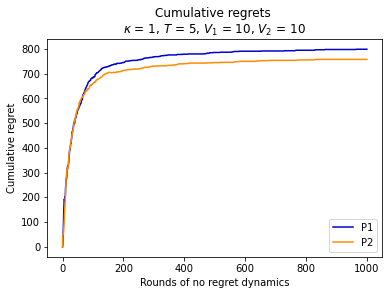

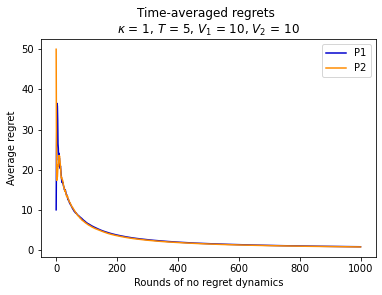

In [14]:
# plot cumulative regrets
plt.plot([0] + p1_regrets , color='mediumblue', label='P1')
plt.plot([0] + p2_regrets, color='darkorange', label='P2')
plt.xlabel('Rounds of no regret dynamics')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regrets \n' + \
                r'$\kappa$' + f' = {kappa}, ' + \
                r'$T$' + f' = {T}, ' + \
                r'$V_1$' + f' = {Va}, ' + \
                r'$V_2$' + f' = {Vb}' )
plt.legend()
plt.show()

# plot time-averaged regrets
plt.plot(p1_regrets_avg , color='mediumblue', label='P1')
plt.plot(p2_regrets_avg, color='darkorange', label='P2')
plt.xlabel('Rounds of no regret dynamics')
plt.ylabel('Average regret')
plt.title(f'Time-averaged regrets \n' + \
                r'$\kappa$' + f' = {kappa}, ' + \
                r'$T$' + f' = {T}, ' + \
                r'$V_1$' + f' = {Va}, ' + \
                r'$V_2$' + f' = {Vb}' )
plt.legend()
plt.show()

### Paper Experiments

In [8]:
def experiments(N, num_rounds, T, epsilon, kappa, Va, Vb, lower_limit, upper_limit, pathname, print_flag=True):
    """
    Run N iterations of no-regret dynamics.

    Args:
        N (int): Number of experiments to run
        num_rounds (int): Number of rounds per experiment
        T (int): Number of time steps
        epsilon (float): Noise parameter for FTPL
        kappa (float): Market impact parameter
        Va (float): Player A's target trading volume
        Vb (float): Player B's target trading volume  
        lower_limit (float): Minimum number of shares that can be traded in one time step
        upper_limit (float): Maximum number of shares that can be traded in one time step
        pathname (str): Path to save results
        print_flag (bool, optional): Whether to print progress. Defaults to True

    Returns:
        tuple: Lists containing results from N experiments:
            - p1_regrets_N: Player 1's regrets
            - p2_regrets_N: Player 2's regrets  
            - p1_regrets_avg_N: Player 1's average regrets
            - p2_regrets_avg_N: Player 2's average regrets
            - tvdists_N: Total variation distances
            - p1_actions_N: Player 1's actions
            - p2_actions_N: Player 2's actions
            - joint_dists_N: Joint distributions over action pairs
    """
    p1_regrets_N = []
    p2_regrets_N = []
    p1_regrets_avg_N = []
    p2_regrets_avg_N = []
    tvdists_N = []

    p1_actions_N = []
    p2_actions_N = []
    joint_dists_N = []

    for n in range(N):

        print(f"Run #{n+1}")

        # run no regret dynamics
        p1_actions, p2_actions, p1_cost_vectors, p2_cost_vectors, p1_costs, p2_costs, p1_regrets, p2_regrets, p1_regrets_avg, p2_regrets_avg = no_regret_dynamics(num_rounds, T, epsilon, kappa, Va, Vb, lower_limit, upper_limit, print_flag=False)

        # store actions, regrets
        p1_actions_N.append(p1_actions)
        p2_actions_N.append(p2_actions)

        p1_regrets_N.append(p1_regrets)
        p2_regrets_N.append(p2_regrets)

        p1_regrets_avg_N.append(p1_regrets_avg)
        p2_regrets_avg_N.append(p2_regrets_avg)

        # construct empirical joint distribution over action pairs
        frequencies = Counter([(tuple(p1_action), tuple(p2_action)) for p1_action, p2_action in zip(p1_actions, p2_actions)])
        joint_dist = {action_pair: freq / num_rounds for action_pair, freq in frequencies.items()}
        joint_dists_N.append(joint_dist)

        # construct marginal distributions over p1 and p2 actions
        p1_frequencies = Counter([tuple(p1_action) for p1_action in p1_actions])
        p1_dist = {action: freq / num_rounds for action, freq in p1_frequencies.items()}
        p2_frequencies = Counter([tuple(p2_action) for p2_action in p2_actions])
        p2_dist = {action: freq / num_rounds for action, freq in p2_frequencies.items()}

        # compute TV distance
        tvdist = 0.0
        for action_pair, action_pair_prob in joint_dist.items():
            p1_action_prob = p1_dist[action_pair[0]]
            p2_action_prob = p2_dist[action_pair[1]]
            tvdist += abs(action_pair_prob - p1_action_prob * p2_action_prob)

        tvdists_N.append(tvdist)

    # compute average TV distance
    if print_flag:
        print(f'avg tv dist: {np.mean(tvdists_N)}')

    # compute average (cumulative) regrets per round
    p1_avg_regrets = np.mean(p1_regrets_N, axis=0)
    p2_avg_regrets = np.mean(p2_regrets_N, axis=0)

    # plot cumulative regrets as function of rounds
    for n in range(N):
        # plots regrets of run n
        plt.plot([0] + p1_regrets_N[n] , color='powderblue')
        plt.plot([0] + p2_regrets_N[n] , color='peachpuff')
    # plot average over N runs
    plt.plot(np.insert(p1_avg_regrets, 0, 0) , label='P1 avg', color='mediumblue')
    plt.plot(np.insert(p2_avg_regrets, 0, 0), label='P2 avg', color='darkorange')
    plt.xlabel('Rounds of no regret dynamics')
    plt.ylabel('Cumulative regret')
    plt.title(f'Cumulative regrets over N={N} runs \n' + \
                r'$\kappa$' + f' = {kappa}, ' + \
                r'$T$' + f' = {T}, ' + \
                r'$V_1$' + f' = {Va}, ' + \
                r'$V_2$' + f' = {Vb}, ' + \
                r'$\theta_L$' + f' = {lower_limit}, ' + \
                r'$\theta_U$' + f' = {upper_limit}'
            )
    plt.legend()
    if not os.path.exists(pathname + '/plots'):
        os.makedirs(pathname + '/plots', exist_ok=True)
    plt.savefig(pathname + f'/plots/regrets-cumulative.pdf')
    if print_flag:
        plt.show()

    # compute average (time-averaged) regrets per round
    p1_avg_regrets_avg = np.mean(p1_regrets_avg_N, axis=0)
    p2_avg_regrets_avg = np.mean(p2_regrets_avg_N, axis=0)

    # plot time-averaged regrets as function of rounds
    for n in range(N):
        # plots regrets of run n
        plt.plot(p1_regrets_avg_N[n] , color='powderblue')
        plt.plot(p2_regrets_avg_N[n] , color='peachpuff')
    # plot average over N runs
    plt.plot(p1_avg_regrets_avg, label='P1 avg', color='mediumblue')
    plt.plot(p2_avg_regrets_avg, label='P2 avg', color='darkorange')
    plt.xlabel('Rounds of no regret dynamics')
    plt.ylabel('Average regret')
    plt.title(f'Time-averaged regrets over N={N} runs \n' + \
                r'$\kappa$' + f' = {kappa}, ' + \
                r'$T$' + f' = {T}, ' + \
                r'$V_1$' + f' = {Va}, ' + \
                r'$V_2$' + f' = {Vb}, ' + \
                r'$\theta_L$' + f' = {lower_limit}, ' + \
                r'$\theta_U$' + f' = {upper_limit}'
            )
    plt.legend()
    plt.savefig(pathname + f'/plots/regrets-average.pdf')
    if print_flag:
        plt.show()

    return p1_actions_N, p2_actions_N, p1_regrets_N, p2_regrets_N, p1_regrets_avg_N, p2_regrets_avg_N, joint_dists_N, tvdists_N

In [ ]:
# set parameters
Va = 10  # shares to buy for A
Vb = 10  # shares to buy for B
T = 5   # number of time steps
lower_limit = -5
upper_limit = 5

kappa_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10]

N = 100
num_rounds = 2500
epsilon = np.sqrt(num_rounds)

# run experiments
for kappa in kappa_list:
    print(f'kappa: {kappa} ================================')
    
    random.seed(0) # set random seed

    # make folder
    pathname = f'trading-experiments/Va{Va}-Vb{Vb}-kappa{kappa}'
    if not os.path.exists(pathname):
        os.makedirs(pathname, exist_ok=True)

    p1_actions_N, p2_actions_N, p1_regrets_N, p2_regrets_N, p1_regrets_avg_N, p2_regrets_avg_N, joint_dists_N, tvdists_N = experiments(N, num_rounds, T, epsilon, kappa, Va, Vb, lower_limit, upper_limit, pathname, print_flag=True)

    # save outputs
    if not os.path.exists(pathname + '/data'):
        os.makedirs(pathname + '/data', exist_ok=True)
    np.save(pathname + '/data/p1_actions_N', p1_actions_N)
    np.save(pathname + '/data/p2_actions_N', p2_actions_N)
    np.save(pathname + '/data/p1_regrets_N', p1_regrets_N)
    np.save(pathname + '/data/p2_regrets_N', p2_regrets_N)
    np.save(pathname + '/data/p1_regrets_avg_N', p1_regrets_avg_N)
    np.save(pathname + '/data/p2_regrets_avg_N', p2_regrets_avg_N)
    np.save(pathname + '/data/joint_dists_N', joint_dists_N)
    np.save(pathname + '/data/tvdists_N', tvdists_N)

#### Compute distances to equilibria

In [10]:
from helpers import swap_regret, dist_to_nash

In [11]:
# compute for P1
p1_avg_dists_to_nash = []
p1_avg_swap_regrets = []
p1_avg_external_regrets = []
p1_std_dists_to_nash = []
p1_std_swap_regrets = []
p1_std_external_regrets = []

# compute for P2
p2_avg_dists_to_nash = []
p2_avg_swap_regrets = []
p2_avg_external_regrets = []
p2_std_dists_to_nash = []
p2_std_swap_regrets = []
p2_std_external_regrets = []

# compute max
avg_max_nash = []
avg_max_SR = []
avg_max_ER = []

std_nash = []
std_SR = []
std_ER = []

for kappa in kappa_list:
    # load data
    p1_actions_N = np.load(f'trading-experiments/Va10-Vb10-kappa{kappa}/data/p1_actions_N.npy', allow_pickle=True)
    p2_actions_N = np.load(f'trading-experiments/Va10-Vb10-kappa{kappa}/data/p2_actions_N.npy', allow_pickle=True)
    p1_regrets_N = np.load(f'trading-experiments/Va10-Vb10-kappa{kappa}/data/p1_regrets_N.npy', allow_pickle=True)
    p2_regrets_N = np.load(f'trading-experiments/Va10-Vb10-kappa{kappa}/data/p2_regrets_N.npy', allow_pickle=True)
    N = len(p1_actions_N)
    num_rounds = len(p1_actions_N[0])
    
    p1_dists_to_nash = []
    p1_swap_regrets = []
    p1_external_regrets = []
    p2_dists_to_nash = []
    p2_swap_regrets = []
    p2_external_regrets = []

    max_nash = []
    max_SR = []
    max_ER = []
    for n in range(N):
        # find dist to Nash equilibrium
        dist1 = dist_to_nash(p1_actions_N[n], p2_actions_N[n], Va, T, kappa, lower_limit, upper_limit)
        p1_dists_to_nash.append(dist1)
        dist2   = dist_to_nash(p2_actions_N[n], p1_actions_N[n], Vb, T, kappa, lower_limit, upper_limit)
        p2_dists_to_nash.append(dist2)

        max_nash.append(max(dist1, dist2))

        # find dist to CE
        sr1 = swap_regret(p1_actions_N[n], p2_actions_N[n], Va, T, kappa, lower_limit, upper_limit) / num_rounds
        sr2 = swap_regret(p2_actions_N[n], p1_actions_N[n], Vb, T, kappa, lower_limit, upper_limit) / num_rounds
        p1_swap_regrets.append(sr1)
        p2_swap_regrets.append(sr2)

        max_SR.append(max(sr1, sr2))

        # find dist to CCE
        # er1 = regret(p1_actions_N[n], p2_actions_N[n], Va, T, kappa, lower_limit, upper_limit) / num_rounds
        # er2 = regret(p2_actions_N[n], p1_actions_N[n], Vb, T, kappa, lower_limit, upper_limit) / num_rounds
        er1 = p1_regrets_N[n][-1] / num_rounds
        er2 = p2_regrets_N[n][-1] / num_rounds
        p1_external_regrets.append(er1)
        p2_external_regrets.append(er2)

        max_ER.append(max(er1, er2))

    # compute max over players
    avg_max_nash.append(np.mean(max_nash))
    avg_max_SR.append(np.mean(max_SR))
    avg_max_ER.append(np.mean(max_ER))

    std_nash.append(np.std(max_nash))
    std_SR.append(np.std(max_SR))
    std_ER.append(np.std(max_ER))

In [ ]:
plt.errorbar(kappa_list, avg_max_nash, std_nash, linestyle='--', marker='o', color="dodgerblue", ecolor = "dimgray", capsize=3, label="Dist. to NE")
plt.errorbar(kappa_list, avg_max_SR, std_SR, linestyle='--', marker='o', color="olivedrab", ecolor = "dimgray", capsize=3, label="Dist. to CE")
plt.errorbar(kappa_list, avg_max_ER, std_ER, linestyle='--', marker='o', color="tomato", ecolor = "dimgray", capsize=3, label="Dist. to CCE")
plt.xlabel(r'$\kappa$', fontsize=18)
plt.ylabel('Distance', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(f'Distances to Equilibria (averaged over N={N} runs)', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('trading-experiments/dists_to_eq.pdf')
plt.show()

#### Compute welfare

In [13]:
from helpers import welfare

In [ ]:
avg_welfares = []
std_welfares = []
for kappa in kappa_list:
    joint_dists_N = np.load(f'trading-experiments/Va10-Vb10-kappa{kappa}/data/joint_dists_N.npy', allow_pickle=True)

    welfares_N = []
    for n in range(N):
        welfares_N.append(welfare(joint_dists_N[n], kappa))
    
    # compute mean and standard deviation
    avg_welfares.append(np.mean(welfares_N))
    std_welfares.append(np.std(welfares_N))

In [ ]:
plt.errorbar(kappa_list, avg_welfares, std_welfares, linestyle='--', marker='o', color="rebeccapurple", ecolor = "dimgray", capsize=3, label="Joint distribution")
plt.xlabel(r'$\kappa$', fontsize=20)
plt.ylabel('Welfare', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(f'Welfare (averaged over N={N} runs)')
plt.tight_layout()
plt.savefig('trading-experiments/welfare.pdf')
plt.show()